In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [6]:
# Load dataset
csv_path = "E:\Github\Sentiment-Analysis-Speech-Emotion-Recognition\Dataset\dataset.csv"  # Update this path
df = pd.read_csv(csv_path)

In [13]:
# Exploratory Data Analysis (EDA)
print("Dataset Overview:")
df.info()
print("\nFirst 5 Rows:")
df.head()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2449 entries, 0 to 2448
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Sentence            2449 non-null   object
 1   Type                2449 non-null   object
 2   Factual/Subjective  2449 non-null   object
 3   Sentiment           2449 non-null   object
dtypes: object(4)
memory usage: 76.7+ KB

First 5 Rows:


,Sentence,Type,Factual/Subjective,Sentiment
0,The sky is blue.,Affirmation,Factual,Neutral
1,I love sunny days!,Affirmation,Subjective,Happiness
2,This pizza is disgusting.,Affirmation,Subjective,Anger
3,Water boils at 100 degrees Celsius.,Affirmation,Factual,Neutral
4,I don't think this is a good idea.,Negation,Subjective,Sadness


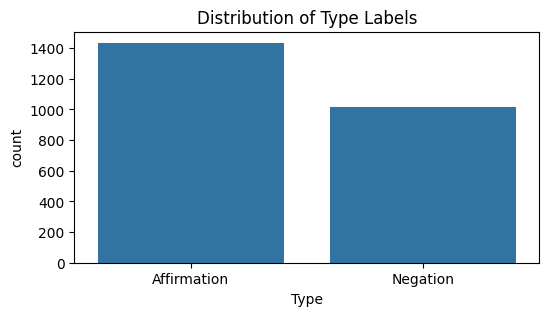

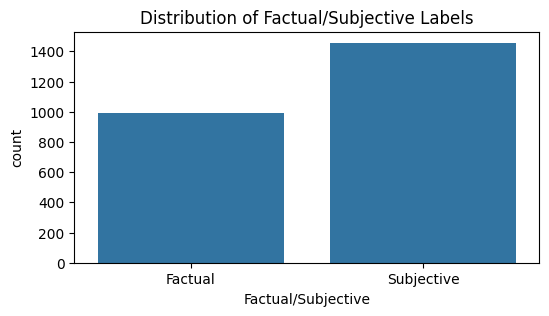

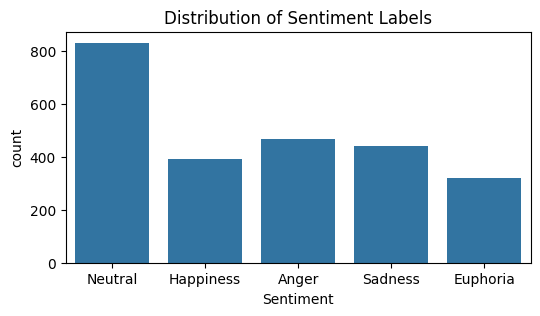

In [12]:
# Plot class distributions
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x="Type")
plt.title("Distribution of Type Labels")
plt.show()

plt.figure(figsize=(6, 3))
sns.countplot(data=df, x="Factual/Subjective")
plt.title("Distribution of Factual/Subjective Labels")
plt.show()

plt.figure(figsize=(6, 3))
sns.countplot(data=df, x="Sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()

In [ ]:
# Initialize sentence embedding model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# Encode sentences into embeddings
embeddings = model.encode(df["Sentence"].tolist())

# Label encoding
type_mapping = {"Affirmation": 0, "Negation": 1}
fact_subj_mapping = {"Factual": 0, "Subjective": 1}
sentiment_mapping = {"Sadness": 0, "Anger": 1, "Neutral": 2, "Happiness": 3, "Euphoria": 4}

df["Type"] = df["Type"].map(type_mapping).fillna(-1).astype(int)
df["Factual/Subjective"] = df["Factual/Subjective"].map(fact_subj_mapping).fillna(-1).astype(int)
df["Sentiment"] = df["Sentiment"].map(sentiment_mapping).fillna(-1).astype(int)

# Convert labels to NumPy arrays
type_labels = df["Type"].values
fact_subj_labels = df["Factual/Subjective"].values
sentiment_labels = df["Sentiment"].values

In [ ]:
# Stratified Train-Test Split (based on Sentiment)
X_train, X_test, y_type_train, y_type_test, y_fact_train, y_fact_test, y_sent_train, y_sent_test = train_test_split(
    embeddings, type_labels, fact_subj_labels, sentiment_labels,
    test_size=0.2, random_state=42, stratify=sentiment_labels
)


In [ ]:
# Hyperparameter Grid for Logistic Regression
logistic_param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

In [ ]:
def train_logistic_regression(X_train, y_train, X_test, y_test, name):
    model = LogisticRegression(max_iter=1000)
    grid_search = GridSearchCV(model, logistic_param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Best Logistic Regression Model for {name}: {grid_search.best_params_}")
    print(f"Accuracy for {name}: {acc:.4f}\n")
    
    return best_model


In [ ]:
# Train and evaluate logistic regression models
type_model = train_logistic_regression(X_train, y_type_train, X_test, y_type_test, "Type Classification")

In [ ]:
# Train and evaluate logistic regression models
fact_model = train_logistic_regression(X_train, y_fact_train, X_test, y_fact_test, "Factual/Subjective Classification")

In [ ]:
# Hyperparameter Grid for XGBoost
xgb_param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
}

def train_xgboost(X_train, y_train, X_test, y_test, name):
    model = XGBClassifier(eval_metric="mlogloss")
    grid_search = GridSearchCV(model, xgb_param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Best XGBoost Model for {name}: {grid_search.best_params_}")
    print(f"Accuracy for {name}: {acc:.4f}\n")
    
    return best_model

In [ ]:
# Train and evaluate XGBoost model
sentiment_model = train_xgboost(X_train, y_sent_train, X_test, y_sent_test, "Sentiment Classification")

In [ ]:
import pickle

# Save Logistic Regression models
with open("type_model.pkl", "wb") as f:
    pickle.dump(type_model, f)

with open("fact_model.pkl", "wb") as f:
    pickle.dump(fact_model, f)

# Save XGBoost model
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(sentiment_model, f)
